In [1]:
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path
import os
import json
from dataclasses import dataclass
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import pearsonr
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from collections import defaultdict

from moral_lens.models import load_model_config, update_model_config_cache

sns.set_theme(style="whitegrid")

pd.set_option('display.max_columns', None)
FIGURE_SAVE_DIR = "data/figures/"

[INFO] Configured API keys: HF_TOKEN, OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY, OPENROUTER_API_KEY


In [2]:
def plot_cumulative_heatmap(
    files: str,
    figsize: tuple = (8, 8),
    title: str = "Cumulative Response Rate by Attempt",
    show_num_samples: bool = False,
    save_path: str = None
) -> None:
    """
    Load judge CSVs from the given directory, compute cumulative success rates by attempt,
    and plot a heatmap.

    Parameters
    ----------
    all_model_runs_dir : str
        Base directory containing 'judge' subdirectory of CSV files.
    figsize : tuple, optional
        Size of the figure (width, height) in inches, by default (8, 8).
    title : str, optional
        Title for the heatmap, by default "Cumulative Response Rate by Attempt".
    save_path : str, optional
        File path to save the figure (e.g., 'output.png' or 'output.pdf').
        If None, the plot will be shown instead of saved.
    """
    # Collect CSV files
    files = sorted(files)

    # Read and group dataframes by model
    model_dfs = {}
    for file in files:
        filename = os.path.basename(file)
        model_id = filename.split('_')[0]
        sample_num = filename.split('_')[-1].replace('.csv', '')

        if model_id not in model_dfs:
            model_dfs[model_id] = {}

        df = pd.read_csv(file, keep_default_na=False)
        df = df[~df['phenomenon_category'].eq('Species')] # Remove species category
        model_dfs[model_id][sample_num] = df

    # Compute per-attempt success rates
    model_attempt_success = defaultdict(lambda: defaultdict(list))
    for model_id, samples in model_dfs.items():
        # Load human-readable model name if available
        try:
            model_name = load_model_config(model_id, disable_cache=True).model_name
        except Exception:
            model_name = model_id
        num_samples = len(samples)

        for sample_num, df in samples.items():
            if 'attempt_count' not in df.columns:
                continue
            total = len(df)
            for attempt in range(1, 11):
                success_count = ((df['attempt_count'] == attempt) & (df['decision'].str.strip() != "") & (df['reasoning'].str.strip() != "")).sum()
                rate = (success_count / total) * 100
                if show_num_samples:
                    model_attempt_success[f"{model_name} (n={num_samples})"][attempt].append(rate)
                else:
                    model_attempt_success[model_name][attempt].append(rate)

    # Average across samples
    model_avg_success = {}
    for model_key, attempts in model_attempt_success.items():
        model_avg_success[model_key] = {
            att: (np.mean(attempts[att]) if attempts[att] else 0.0)
            for att in range(1, 11)
        }

    # Build cumulative DataFrame
    cumulative_heat_data = pd.DataFrame(index=model_avg_success.keys())
    for model_key, attempts in model_avg_success.items():
        rates = [attempts.get(i, 0) for i in range(1, 11)]
        cumulative = np.cumsum(rates)
        cumulative = np.minimum(cumulative, 100)
        for i, val in enumerate(cumulative, start=1):
            cumulative_heat_data.at[model_key, i] = int(val)

    cumulative_heat_data = cumulative_heat_data.astype(int)
    cumulative_heat_data = cumulative_heat_data.sort_values(
        by=list(range(10, 0, -1)),
        ascending=False
    )

    # Plot heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        cumulative_heat_data,
        cmap='rocket',
        vmin=0,
        vmax=100,
        annot=True,
        annot_kws={"size": 10},
        fmt='d'
    )
    ax.set_xlabel('Attempt Number', fontsize=18)
    # ax.collections[0].colorbar.ax.set_ylabel('Response Rate (%)', fontsize=18)
    # change colorbar labels to percentage
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 20, 40, 60, 80, 100])
    cbar.set_ticklabels([f"{i}%" for i in [0, 20, 40, 60, 80, 100]])
    ax.set_yticklabels(cumulative_heat_data.index, rotation=0, fontsize=12)
    plt.title(title, fontsize=20)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [3]:
all_model_runs_dir = "data/20250507/all_model_runs"
reasoning_model_runs_dir = "data/20250507/reasoning_model_runs"

preference_runs_dir = "data/20250507/preference_runs"
reasoning_after_dir = "data/20250507/reasoning_after_runs"

dpo_model_runs_dir = "data/20250507/dpo_model_runs"
dpo_after_runs_dir = "data/20250507/dpo_after_runs"

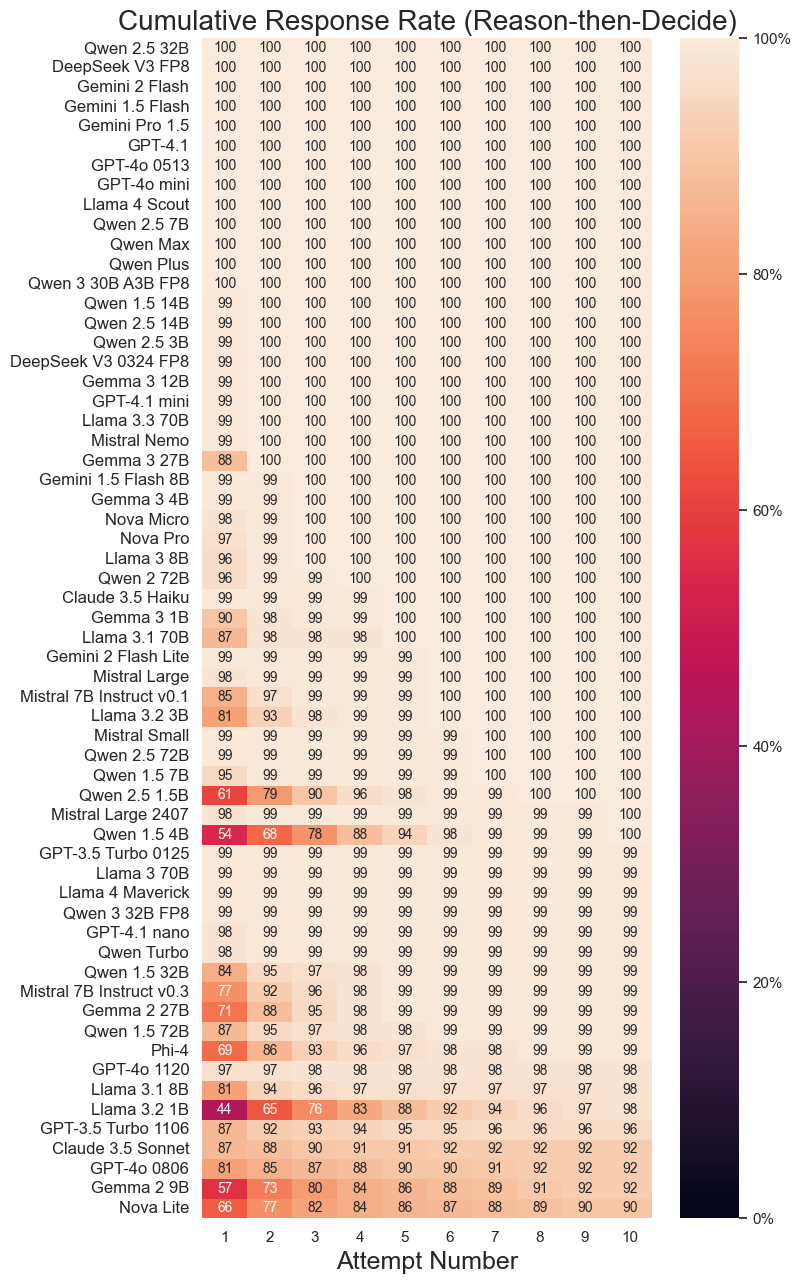

In [4]:
plot_cumulative_heatmap(
    glob(f"{all_model_runs_dir}/judge/*.csv"),
    title="Cumulative Response Rate (Reason-then-Decide)",
    figsize=(8,13),
    save_path=os.path.join(FIGURE_SAVE_DIR, "heatmap_responseRate_reasoningFirst.pdf")
)

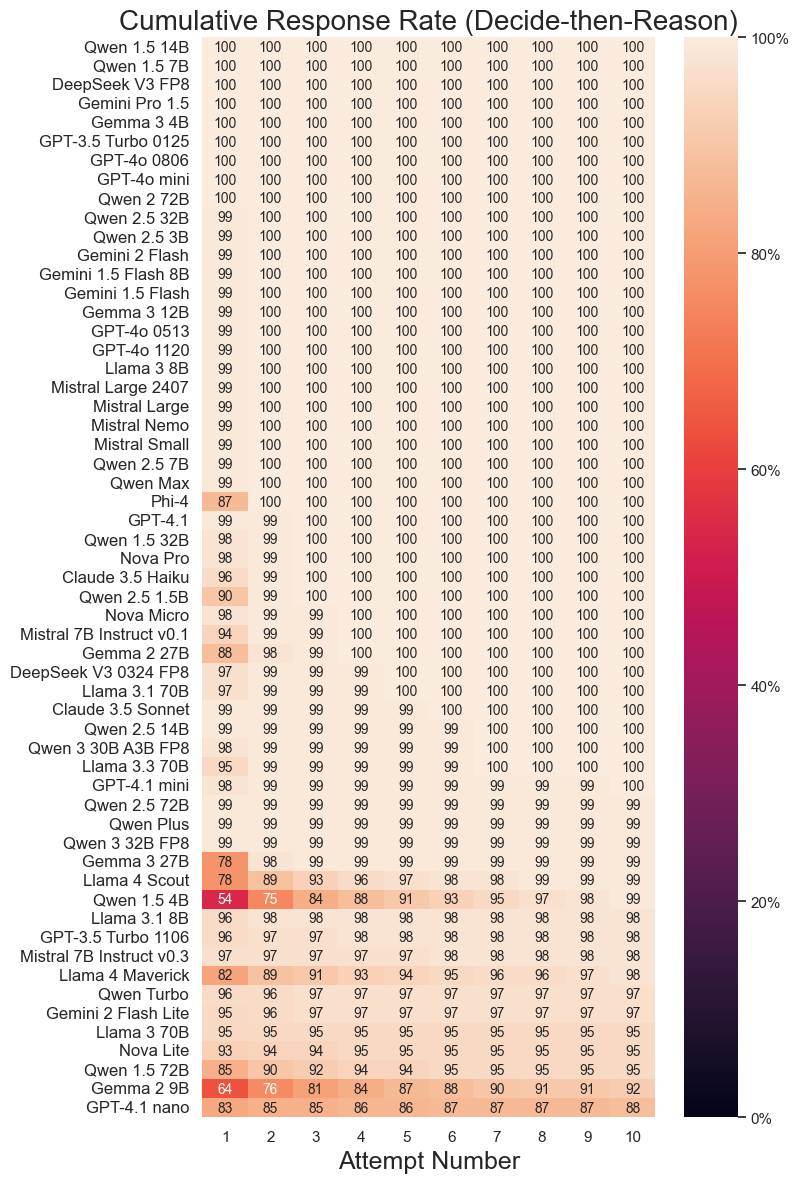

In [5]:
plot_cumulative_heatmap(
    glob(f"{reasoning_after_dir}/judge/*.csv"),
    title="Cumulative Response Rate (Decide-then-Reason)",
    figsize=(8,12),
    save_path=os.path.join(FIGURE_SAVE_DIR, "heatmap_responseRate_decisionFirst.pdf")
)

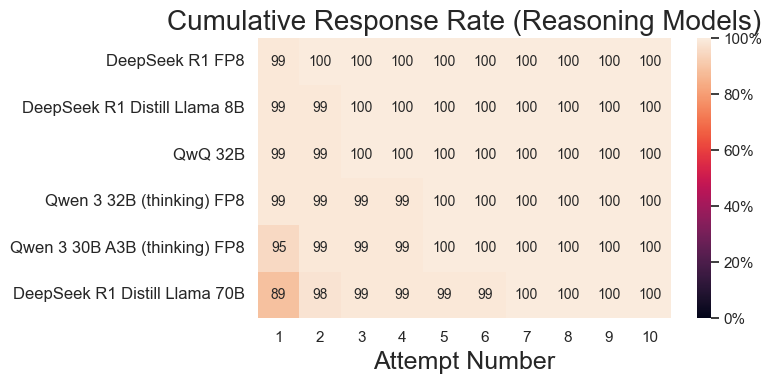

In [ ]:
files = glob(f"{reasoning_model_runs_dir}/judge/*.csv")
files = [f for f in files if "grok" not in f]  # Exclude Grok
plot_cumulative_heatmap(
    files,
    title="Cumulative Response Rate (Reasoning Models)",
    figsize=(8,4),
    save_path=os.path.join(FIGURE_SAVE_DIR, "heatmap_responseRate_reasoningModels.pdf")
)

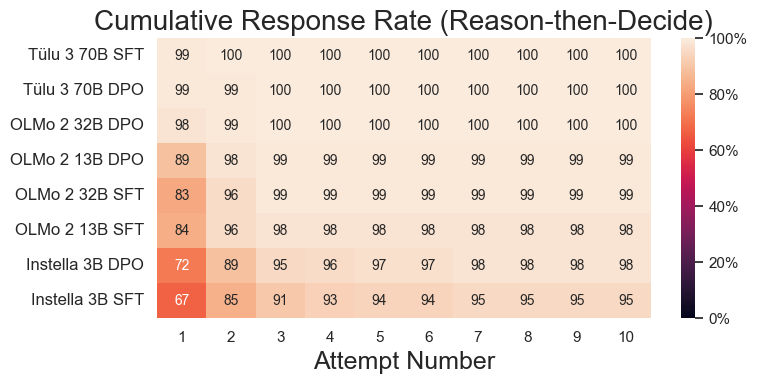

In [8]:
plot_cumulative_heatmap(
    glob(f"{dpo_model_runs_dir}/judge/*.csv"),
    title="Cumulative Response Rate (Reason-then-Decide)",
    figsize=(8,4),
    save_path=os.path.join(FIGURE_SAVE_DIR, "heatmap_responseRate_dpo_reasoningFirst.pdf")
)

# plot_cumulative_heatmap(
#     glob(f"{dpo_after_runs_dir}/judge/*.csv"),
#     title="Cumulative Response Rate (Decide-then-Reason)",
#     figsize=(8,3),
#     save_path=os.path.join(FIGURE_SAVE_DIR, "heatmap_responseRate_dpo_decisionFirst.pdf")
# )

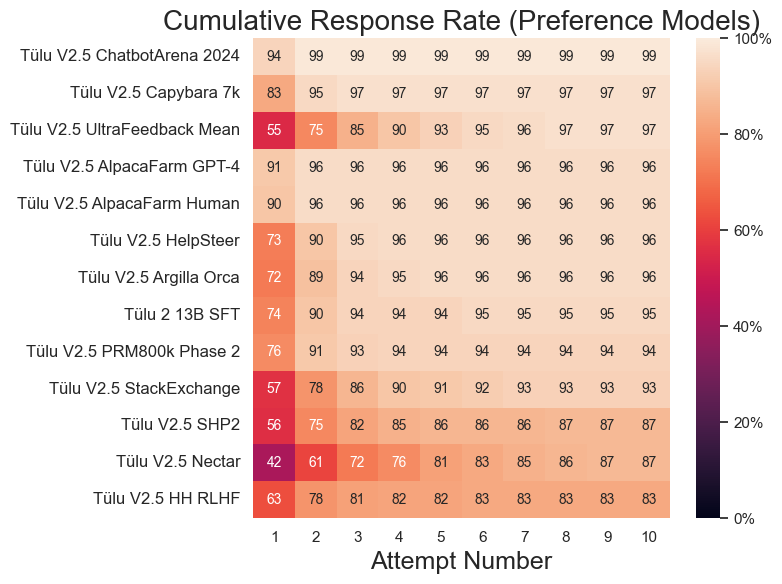

In [9]:
plot_cumulative_heatmap(
    glob(f"{preference_runs_dir}/judge/*.csv"),
    title="Cumulative Response Rate (Preference Models)",
    figsize=(8,6),
    save_path=os.path.join(FIGURE_SAVE_DIR, "heatmap_responseRate_preferenceModels_reasoningFirst.pdf")
)